# Data preparation

## Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_gestures import load_gestures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

## Datos

### Cargamos los gestos mediante la función `load_gestures()` escrita por nosotros

In [2]:
df = load_gestures("files/")

### Vemos dimensiones

In [3]:
df.shape

(20628, 9)

### Checamos duplicados, omitimos el temporal_point igual a cero ya que hay muchos con valores iguales. Queremos solamente gestos completos

In [4]:
duplicates = df[df["temporal_point"] != 0]  # Omitimos 0 ya que hay muchos puntos iniciales repetidos

duplicates = duplicates[duplicates.duplicated(
    subset=["temporal_point", "x", "y", "height", "width", "finger_pressure"])] # Para que un gesto sea duplicado, deben coincidir todas sus coordenadas

unique_gestures = duplicates.groupby(["user", "gesture"])["sample"].nunique()   # Extraemos el gesto completo

print(f"Filas duplicadas: {len(duplicates)}")    # Puntos temporales duplicados 
print(f"Gestos duplicados: {len(unique_gestures)}") # Gestos completos duplicados

Filas duplicadas: 14
Gestos duplicados: 1


### Gestos a eliminar

In [5]:
duplicates_to_drop = duplicates[["user", "gesture", "sample"]].drop_duplicates()    # Los gestos a eliminar

### Merge para eliminar 

In [6]:
df = df.merge(duplicates_to_drop, on=["user", "gesture", "sample"], how="left", indicator=True) # Hacemos un merge por la izquierda

df = df[df["_merge"] == "left_only"].drop(columns="_merge") # Eliminamos la columna "_merge" en el df original y nos quedamos con los datos de la izquierda

### Dimensiones después de unir

In [7]:
df.shape

(20613, 9)

## Preparación de conjuntos X_train y X_test

### Creamos un array sample_info, que son tuplas con user, gesture y sample que corresponderán con X, para luego ser divididos en X_train y X_test

In [8]:
sample_info = [(user, gesture, sample) 
               for (user, gesture, sample), _ in df.groupby(["user","gesture","sample"])]
sample_info = np.array(sample_info)

### Hacemos un arreglo con todos los gestos, de manera que cada linea corresponda con una muestra de gesto único, poniendo en cada fila los valores "x", "y", "height", "width", y "finger_pressure"

In [9]:
max_rows = max(len(sample_df) for _, sample_df in df.groupby(["user","gesture","sample"]))

X = []
y = []

# Agrupar por muestra
for (_, gesture, _), sample_df in df.groupby(["user","gesture","sample"]):
    feature_vector = sample_df[["x", "y", "height", "width", "finger_pressure"]].values.flatten()
    pad_length = max_rows*5 - len(feature_vector)  # 5 columnas por fila
    if pad_length > 0:
        feature_vector = np.pad(feature_vector, (0, pad_length), "constant")
    X.append(feature_vector)
    y.append(gesture)

X = np.array(X)
y = np.array(y)

### Hacemos un group shuffle split por usuario, de forma en la que solamente unos usuarios queden en el training set y otros queden en el test set, así generalizmaos por usuarios

In [10]:
users = np.array([user for (user, _, _) in df.groupby(["user","gesture","sample"]).groups.keys()])
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=users))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
sample_info_train = sample_info[train_idx]
sample_info_test = sample_info[test_idx]

#### Escalamos los datos 

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## PCA

### Al tener alta dimensionalidad, tenemos que hacer un PCA para reducción de dimensión, para esto verificamos la varianza explicada por número de componentes

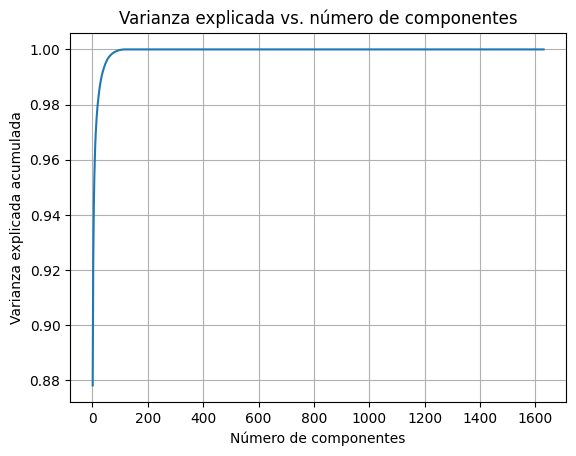

In [12]:
pca = PCA()
pca.fit(X_train_scaled)

explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada vs. número de componentes")
plt.grid(True)
plt.show()

### Número de componentes para una varianza en los datos de 95%

In [13]:
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Número de componentes para una varianza de 95%: {n_components_95}")

Número de componentes para una varianza de 95%: 7


### PCA con el número de componentes previamente computado

In [14]:
pca = PCA(n_components=n_components_95)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

## KNN

### KNN con número de vecinos 

In [15]:
k_values = range(1, 31)  # Probamos k de 1 a 10
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Hacemos cross-validation con 5 folds
    scores = cross_val_score(knn, X_train_reduced, y_train, cv=5)
    cv_scores.append(scores.mean())

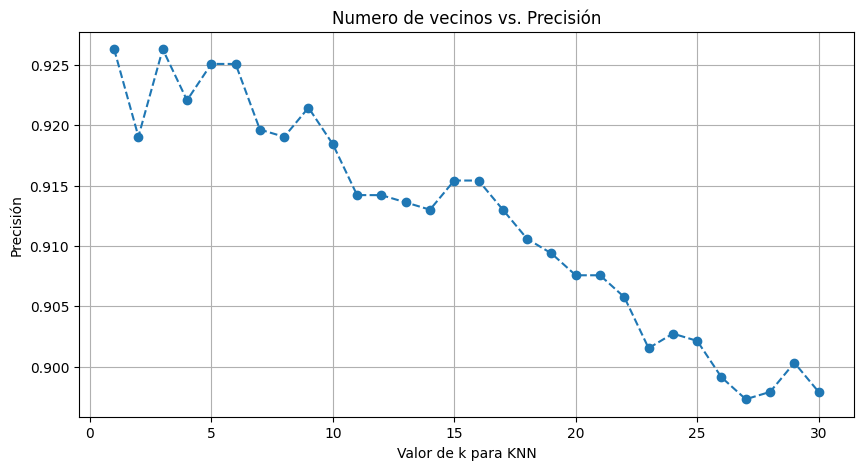

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker="o", linestyle="--")
plt.title("Numero de vecinos vs. Precisión")
plt.xlabel("Valor de k para KNN")
plt.ylabel("Precisión")
plt.grid(True)
plt.show()

In [17]:
best_k = k_values[np.argmax(cv_scores)]
print("Mejor k:", best_k)

Mejor k: 1


### Escogemos k = 9, ya que maximiza precisión y minimiza overfitting 

In [18]:
best_k = 9

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_reduced, y_train)

,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### Precisión y reporte de clasificación

In [19]:
y_pred = knn.predict(X_test_reduced)
print("Precisión:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Precisión: 0.9369158878504673
              precision    recall  f1-score   support

  gesture_01       1.00      0.96      0.98        57
  gesture_02       0.95      0.96      0.95        54
  gesture_03       0.93      0.93      0.93        54
  gesture_04       0.95      0.90      0.92        60
  gesture_05       0.95      0.95      0.95        56
  gesture_06       0.97      0.84      0.90        38
  gesture_07       0.94      0.94      0.94        54
  gesture_08       0.84      0.98      0.91        55

    accuracy                           0.94       428
   macro avg       0.94      0.93      0.94       428
weighted avg       0.94      0.94      0.94       428



### Matriz de confusión

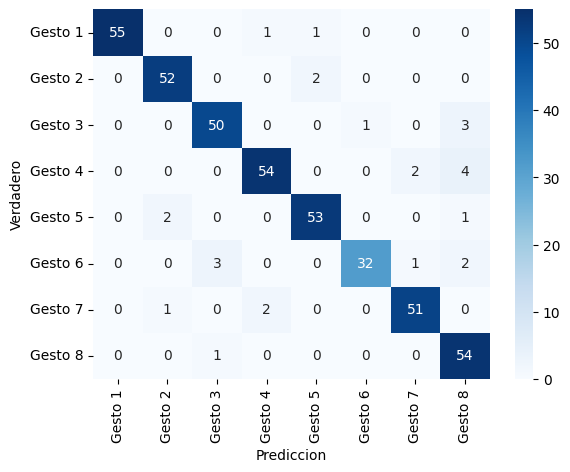

In [20]:
y_pred = knn.predict(X_test_reduced)
cm = confusion_matrix(y_test, y_pred)
target_names = [f"Gesto {i}" for i in range(1, len(np.unique(y_test)) + 1)]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Prediccion")
plt.ylabel("Verdadero")
plt.show()

### Cross-validation

In [21]:
groups = users

### Pipeline de los procesos para Cross-validation

In [22]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_components_95)),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])

### Iteramos los usuarios cinco veces sobre los conjuntos X, y

In [23]:
gkf = GroupKFold(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=gkf, groups=groups)

### Precisión con cross validation

In [24]:
print("Precisión con cross-validation:", scores)
print("Precisión promedio:", scores.mean())

Precisión con cross-validation: [0.95128205 0.98588235 0.56316916 0.83830846 0.9425    ]
Precisión promedio: 0.8562284053633794


### Verificamos overfitting

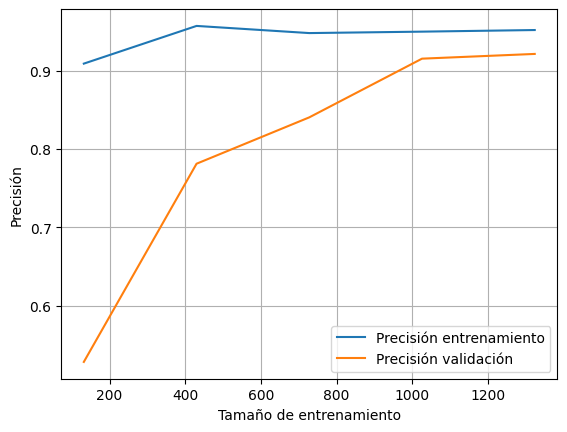

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train_reduced, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Precisión entrenamiento")
plt.plot(train_sizes, test_mean, label="Precisión validación")
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

### Extracción del training y test set

In [26]:
unique_users_train = np.unique(sample_info_train[:, 0])
unique_users_test = np.unique(sample_info_test[:, 0])

print("Usuarios en el training set:", unique_users_train)
print("Usuarios en el test set:", unique_users_test)

Usuarios en el training set: ['user_01' 'user_03' 'user_04' 'user_05' 'user_06' 'user_07' 'user_08'
 'user_10']
Usuarios en el test set: ['user_02' 'user_09']


### Training set

In [27]:
# columns_features = [f"f{i}" for i in range(X_train.shape[1])]
# df_train = pd.DataFrame(X_train, columns=columns_features)
# df_train["gesture"] = y_train

# # Incluir user y sample
# if "sample_info_train" in locals():
#     users, gestures, samples = zip(*sample_info_train)
#     df_train["user"] = users
#     df_train["sample"] = samples

# # Guardar CSV
# df_train.to_csv("training_set.csv", index=False)
# print("Training set guardado en training_set.csv")

### Test set

In [28]:
# columns_features = [f"f{i}" for i in range(X_test.shape[1])]
# df_test = pd.DataFrame(X_test, columns=columns_features)
# df_test["gesture"] = y_test

# users_test, gestures_test, samples_test = zip(*sample_info_test)
# df_test["user"] = users_test
# df_test["sample"] = samples_test

# df_test.to_csv("test_set.csv", index=False)
# print("Test set guardado en test_set.csv")

## Misc

In [29]:
counts = df.groupby(["user", "gesture"]).size().reset_index(name="num_samples")

print(counts)

       user     gesture  num_samples
0   user_01  gesture_01          153
1   user_01  gesture_02          209
2   user_01  gesture_03          171
3   user_01  gesture_04          210
4   user_01  gesture_05          198
..      ...         ...          ...
75  user_10  gesture_04          264
76  user_10  gesture_05          208
77  user_10  gesture_06           77
78  user_10  gesture_07          176
79  user_10  gesture_08          269

[80 rows x 3 columns]


In [30]:
gestures_counts = df.groupby("gesture").size().reset_index(name="num_samples")
print(gestures_counts)

      gesture  num_samples
0  gesture_01         2477
1  gesture_02         2833
2  gesture_03         2497
3  gesture_04         2644
4  gesture_05         2602
5  gesture_06         2352
6  gesture_07         2557
7  gesture_08         2651


In [31]:
users_counts = df.groupby("user").size().reset_index(name="num_samples")
print(users_counts)

      user  num_samples
0  user_01         1507
1  user_02         2381
2  user_03         2195
3  user_04         3442
4  user_05         1853
5  user_06         1132
6  user_07         2136
7  user_08         2356
8  user_09         1835
9  user_10         1776


In [32]:
for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
    train_users = np.unique(groups[train_idx])
    test_users = np.unique(groups[test_idx])
    
    print(f"Fold {i}:")
    print(f"  Train users: {train_users}")
    print(f"  Test users: {test_users}")

Fold 1:
  Train users: ['user_02' 'user_03' 'user_05' 'user_06' 'user_07' 'user_08' 'user_09'
 'user_10']
  Test users: ['user_01' 'user_04']
Fold 2:
  Train users: ['user_01' 'user_03' 'user_04' 'user_05' 'user_06' 'user_08' 'user_09'
 'user_10']
  Test users: ['user_02' 'user_07']
Fold 3:
  Train users: ['user_01' 'user_02' 'user_04' 'user_05' 'user_07' 'user_08' 'user_09'
 'user_10']
  Test users: ['user_03' 'user_06']
Fold 4:
  Train users: ['user_01' 'user_02' 'user_03' 'user_04' 'user_06' 'user_07' 'user_08'
 'user_10']
  Test users: ['user_05' 'user_09']
Fold 5:
  Train users: ['user_01' 'user_02' 'user_03' 'user_04' 'user_05' 'user_06' 'user_07'
 'user_09']
  Test users: ['user_08' 'user_10']
